In [1]:
%matplotlib inline

In [2]:
import time
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from dataload import lang, localdata
from tagger.charbilstm import CharBiLSTM
from etc.customUtil import showGraph, showParallel
from etc import defaultsetting as ds

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
tag_PAD = ds.TOKKEN_PAD_IDX
tag_UNK = ds.TOKKEN_UNK_IDX

datasets, engdict, posdict = localdata.load_eng_pos(device, strmode=True) # , charmode=True)
num_words = engdict.n_words
num_chars = engdict.n_chars
num_poss = posdict.n_words
print(num_words)
print(num_chars)
print(num_poss)
# print(MAX_LENGTH)
print(engdict.max_len_char)
print(engdict.max_len_word)
print(posdict.max_len_char)
print(posdict.max_len_word)

print(len(datasets['dev'].y_data))
print(len(datasets['test'].y_data))
print(len(datasets['train'].y_data))

21591
82
46
54
78
4
78
936
2012
8000


In [5]:
def iteration(samples, optimizer, criterion):
    x_train, y_train = samples
        
    optimizer.zero_grad()

    o = model(engdict, device, x_train)
    o = o.view(-1,o.size(-1))
    t = y_train.view(-1)

    loss = criterion(o, t)
    loss.backward()
    optimizer.step()

    return loss.item()

In [6]:
def epoch(model, optimizer, criterion, dataloader):
    model.train()
    list_loss = []
    for batch_idx, samples in enumerate(dataloader):
        loss = iteration(samples, optimizer, criterion)
        list_loss.append(loss)
    return list_loss

In [7]:
def evaluate(model, criterion, dataloader):
    model.eval()
    total_loss = 0
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples

        o = model(engdict, device, x_train)
        o = o.view(-1,o.size(-1))
        t = y_train.view(-1)

        total_loss += criterion(o, t).item()

        # if batch_idx % 100 == 0:
            # print(batch_idx, loss.item())
            
    # print(batch_idx, loss.item())
    return total_loss / (batch_idx+1)

In [8]:
def scores(model, dataset, batch_size):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    total_samples = len(dataset)
    cnt_corr_samples = 0
    total_words = 0
    cnt_corr_words = 0
    c = posdict.n_words
    table = torch.zeros(c,c)
    
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples
        
        o = model(engdict, device, x_train)
        t = y_train.view(-1)

        __tagged, tagged = torch.max(o, dim=-1)
        
        for i in range(y_train.size(0)):
            l = y_train[i].tolist()
            if tag_PAD in l:
                seq_len = l.index(tag_PAD)
            else:
                seq_len = len(l)
            
            _y = y_train[i,:seq_len]
            _p = tagged[i,:seq_len]
            d = _p!=_y
            cnt_wrong = _p[d].size()[0]
            
            # score1_acc_sample
            if cnt_wrong == 0:
                cnt_corr_samples +=1
                
            # score2_acc_word
            total_words += seq_len
            cnt_corr_words += seq_len - cnt_wrong
            
            # score3_f1
            for j in range(seq_len):
                table[_y[j],_p[j]] += 1

    tp = torch.tensor([table[i,i] for i in range(c)])[2:]
    d0sum = table[2:,2:].sum(dim=0)
    d1sum = table[2:,2:].sum(dim=1)
    allsum = d1sum.sum()
    
    pr = tp / d0sum
    temp = pr != pr
    pr[temp] = 0
    
    re = tp / d1sum
    temp = re != re
    re[temp] = 0
    
    f1 = 2 * pr * re / (pr + re)
    temp = f1 != f1
    f1[temp] = 0
    
    avg_f1 = (f1 * d1sum).sum() / allsum
  
    return (cnt_corr_samples / total_samples,
            cnt_corr_words / total_words,
            avg_f1.item())

In [9]:
def train_losses_scores(model, optimizer, criterion, datasets, batch_size, num_epoch):

    dict_losses={'train': [],
                 'dev': [],
                 'test': []
                }
    
    dict_scores={'train': [[],[],[]],
                 'dev': [[],[],[]],
                 'test': [[],[],[]]
                }
    best_dev_f1 = 0.0
    for epoch_i in range(1,num_epoch+1):
        dataloader = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True)
        dataloader_dev = DataLoader(datasets['dev'], batch_size=batch_size, shuffle=True)
        dataloader_test = DataLoader(datasets['test'], batch_size=batch_size, shuffle=True)
        print(f'\r{epoch_i}', end='')
        temp = epoch(model, optimizer, criterion, dataloader)
        dict_losses['train'].extend(temp)
        dict_losses['dev'].append(evaluate(model, criterion, dataloader_dev))
        dict_losses['test'].append(evaluate(model, criterion, dataloader_test))

        s_train = scores(model, datasets['train'], 100)
        s_dev = scores(model, datasets['dev'], 100)
        s_test = scores(model, datasets['test'], 100)
        
        dict_scores['train'][0].append(s_train[0])
        dict_scores['train'][1].append(s_train[1])
        dict_scores['train'][2].append(s_train[2])
        dict_scores['dev'][0].append(s_dev[0])
        dict_scores['dev'][1].append(s_dev[1])
        dict_scores['dev'][2].append(s_dev[2])
        dict_scores['test'][0].append(s_test[0])
        dict_scores['test'][1].append(s_test[1])
        dict_scores['test'][2].append(s_test[2])
        
        if s_dev[2] > best_dev_f1:
            print(f' epoch Dev F1 score: {best_dev_f1:.6} -> {s_dev[2]:.6}')
            best_dev_f1 = s_dev[2]
            torch.save(model, 'best_char_bilstm_pos.pt')
    print()
    return dict_losses, dict_scores

In [10]:
def pos_tagging(model, input_seq):
    model.eval()
    o = model(engdict, device, input_seq)
    __tagged, tagged = torch.max(o, dim=-1)
    return tagged

In [11]:
def calc(model, input_seq, target_seq=None):
    # input_seq = engdict.tensorFromSentence(input_seq, device)
    # input_list = engdict.sentenceFromIndexes(input_seq.tolist())
    input_list = input_seq.split()

    # print(input_list)
    # print(sentenceFromIndexes(posdict, target_seq.tolist()))
    output_list = posdict.sentenceFromIndexes(pos_tagging(model, [input_seq]).view(-1).tolist())
    
    target_list = None
    if target_seq is not None:
        target_list = posdict.sentenceFromIndexes(target_seq.tolist())

#     print(output_list)
    showParallel(input_list, output_list, target_list)

In [12]:
# embedding_dim = 100
char_dim = 10
word_dim = 50
size_hidden = 50
num_layers = 1
size_out = num_poss
size_batch = 100
# criterion  = nn.CrossEntropyLoss().to(device)
criterion  = nn.CrossEntropyLoss(ignore_index=tag_PAD).to(device)

In [13]:
model = CharBiLSTM(num_chars, num_words, char_dim, word_dim, size_hidden, size_out, num_layers, tag_PAD).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epoch = 60
st = time.time()
dict_losses, dict_scores = train_losses_scores(model, optimizer, criterion, datasets, size_batch, num_epoch)
print(f'\t{time.time()-st:5}')

1 epoch Dev F1 score: 0.0 -> 0.676364
2 epoch Dev F1 score: 0.676364 -> 0.874126
3 epoch Dev F1 score: 0.874126 -> 0.911211
4 epoch Dev F1 score: 0.911211 -> 0.93116
5 epoch Dev F1 score: 0.93116 -> 0.941436
6 epoch Dev F1 score: 0.941436 -> 0.946771
7 epoch Dev F1 score: 0.946771 -> 0.952017
8 epoch Dev F1 score: 0.952017 -> 0.952625
9 epoch Dev F1 score: 0.952625 -> 0.956449
10 epoch Dev F1 score: 0.956449 -> 0.958189
11 epoch Dev F1 score: 0.958189 -> 0.960031
13 epoch Dev F1 score: 0.960031 -> 0.961163
14 epoch Dev F1 score: 0.961163 -> 0.961284
16 epoch Dev F1 score: 0.961284 -> 0.964608
20 epoch Dev F1 score: 0.964608 -> 0.964782
21 epoch Dev F1 score: 0.964782 -> 0.965414
23 epoch Dev F1 score: 0.965414 -> 0.965985
28 epoch Dev F1 score: 0.965985 -> 0.966312
29 epoch Dev F1 score: 0.966312 -> 0.967204
53 epoch Dev F1 score: 0.967204 -> 0.967742
55 epoch Dev F1 score: 0.967742 -> 0.968502
59 epoch Dev F1 score: 0.968502 -> 0.968516
60
	4513.995043754578


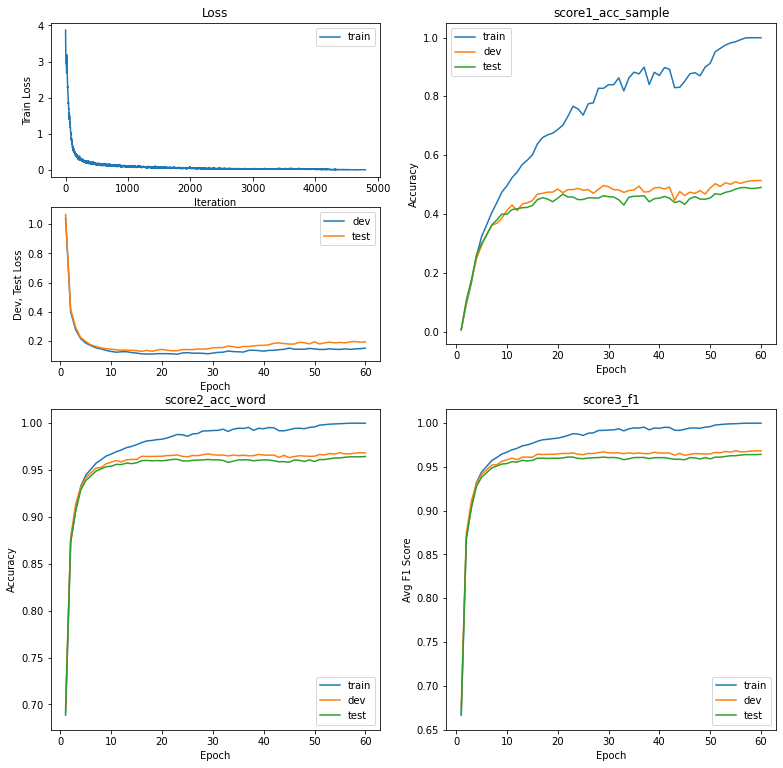

In [14]:
showGraph(dict_losses, dict_scores)

In [15]:
score_type=2
for i in range(len(dict_scores["train"][score_type])):
    print(f'{dict_scores["train"][score_type][i]:<.5}   {dict_scores["dev"][score_type][i]:<05.4}   {dict_scores["test"][score_type][i]:.5}')

0.66641   0.6764   0.66862
0.86761   0.8741   0.86913
0.90484   0.9112   0.90307
0.93223   0.9312   0.92782
0.94411   0.9414   0.93821
0.95065   0.9468   0.94346
0.95721   0.952   0.94878
0.96083   0.9526   0.95106
0.96477   0.9564   0.95332
0.96694   0.9582   0.95388
0.96953   0.960   0.95601
0.97131   0.9583   0.95548
0.97401   0.9612   0.95762
0.97517   0.9613   0.95669
0.97701   0.961   0.95753
0.97928   0.9646   0.95999
0.98099   0.9642   0.96
0.98154   0.9644   0.95969
0.98234   0.9644   0.95992
0.98289   0.9648   0.95989
0.98422   0.9654   0.96037
0.986   0.9654   0.96126
0.98796   0.966   0.96126
0.98758   0.9645   0.95969
0.98601   0.964   0.95949
0.98848   0.9654   0.96019
0.98892   0.9652   0.96052
0.99166   0.9663   0.96067
0.99175   0.9672   0.9612
0.99216   0.9661   0.96069
0.99232   0.966   0.96083
0.9936   0.9661   0.96011
0.99123   0.9651   0.95825
0.99353   0.966   0.95935
0.99458   0.9653   0.96071
0.99438   0.966   0.96079
0.99546   0.9652   0.96083
0.99233   0.9652

In [16]:
testset = datasets['test']
for ii in range(len(testset)):
    i = 0
    input_seq = testset.x_data[i]
    target_seq = testset.y_data[i]
    calc(model, input_seq, target_seq)
    break
#     print(target_seq)

words               tags    targets
Rockwell            NNP     NNP
International       NNP     NNP
Corp.               NNP     NNP
's                  POS     POS
Tulsa               NNP     NNP
unit                NN      NN
said                VBD     VBD
it                  PRP     PRP
signed              VBD     VBD
a                   DT      DT
tentative           JJ      JJ
agreement           NN      NN
extending           VBG     VBG
its                 PRP$    PRP$
contract            NN      NN
with                IN      IN
Boeing              NNP     NNP
Co.                 NNP     NNP
to                  TO      TO
provide             VB      VB
structural          JJ      JJ
parts               NNS     NNS
for                 IN      IN
Boeing              NNP     NNP
's                  POS     POS
747                 CD      CD
jetliners           NNS     NNS
.                   .       .


In [17]:
sen = 'I am your father .'
# in_sen = torch.tensor(engdict.indexesFromSentence(sen), device=device)

# sen2 = [4609,   25,   35,  116, 4610, 1562,   74,  115, 4611,   49, 4612, 1456,
#         4613,  224,  691,    6, 4614,   76,   30, 1742, 4615,  308,  107, 4614,
#          116, 4616, 4617,   17]
# in_sen = torch.tensor(sen2, device=device)

calc(model, sen)

words               tags
I                   PRP
am                  VBP
your                PRP$
father              JJ
.                   .


In [18]:
best_model = torch.load('best_char_bilstm_pos.pt')
s_dev = scores(best_model, datasets['dev'], 100)
s_test = scores(best_model, datasets['test'], 100)
print(s_dev)
print(s_test)

(0.5138888888888888, 0.9684449489216799, 0.9685155153274536)
(0.4875745526838966, 0.9640965025223209, 0.9640617966651917)
